In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import statistics as st
import math

### Read both csv files and assign headers

In [3]:
df1 = pd.read_csv('Edited-INFORM Risk 2024.csv')

In [4]:
#df1.head()

In [5]:
df1 = df1.drop(columns='Unnamed: 0')

In [6]:
data = pd.read_csv('INFORM_Severity-Feb2024.csv', encoding='unicode_escape')

In [7]:
#data.head()

In [8]:
data = data.drop(index=[0,1], axis=0)

In [9]:
#data.head()

In [68]:
pd.options.display.max_rows = 1000

### Replace 'x' with null

In [11]:
data.replace(to_replace='x', value=None, inplace=True)

### Convert numerical columns to floats

In [12]:
#for column in data.columns:
    #print(column, data[column][4])

In [13]:
columns = ['INFORM Severity Index','INFORM Severity category', 'Impact of the crisis', 'Geographical','Human',  
           'Conditions of people affected', 'People in need', 'Concentration of conditions', 'Complexity of the crisis', 
           'Society and safety', 'Operating environment']
data[columns] = data[columns].astype(float)

### Fill remaining null values using mean imputation

In [14]:
#data.isna().sum()

In [15]:
for col in columns:
    data[col] = data[col].fillna(value=data[col].mean())

In [16]:
#data.isna().sum()

### Drop columns that you don't need 

In [17]:
coltodrop = ['Reliability','Geographical','Human', 'People in need', 'Concentration of conditions', 'Society and safety', 'Operating environment']
data = data.drop(columns=coltodrop)

### Reset index

In [18]:
data = data.reset_index(drop=True)

In [19]:
#data.index = range(1, len(data) + 1)

In [20]:
#data.head()

### Transform strings to list of strings
#### ** separated by comma

In [21]:
data['Split Country'] = None
data['Split ISO'] = None

for i, cou in enumerate(data['COUNTRY']):
    data['Split Country'][i] = cou.split(",")
    
for i, cou in enumerate(data['ISO3']):
    data['Split ISO'][i] = cou.split(",")

C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\216856572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Split Country'][i] = cou.split(",")
C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\216856572.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Split ISO'][i] = cou.split(",")


In [22]:
data.head()

,CRISIS,CRISIS ID,COUNTRY,ISO3,DRIVERS,INFORM Severity Index,INFORM Severity category,INFORM Severity category.1,Trend (last 3 months),Impact of the crisis,Conditions of people affected,Complexity of the crisis,Regions,Split Country,Split ISO
0,Complex crisis in Afghanistan,AFG001,Afghanistan,AFG,"Conflict,Violence,Displacement,Drought,Earthqu...",4.4,5.0,Very High,Stable,4.8,4.5,4.0,Asia,[Afghanistan],[AFG]
1,Earthquake in Herat Province,AFG006,Afghanistan,AFG,Earthquake,2.8,3.0,Medium,Stable,2.5,2.7,3.3,Asia,[Afghanistan],[AFG]
2,Drought in South-West Angola,AGO002,Angola,AGO,Drought,3.1,4.0,High,Increasing,2.8,3.9,2.2,Africa,[Angola],[AGO]
3,Nagorno-Karabakh Conflict in Armenia,ARM002,Armenia,ARM,"Conflict,Displacement",2.3,3.0,Medium,Increasing,2.3,2.5,2.0,Middle east,[Armenia],[ARM]
4,Nagorno-Karabakh conflict in Azerbaijan,AZE002,Azerbaijan,AZE,"Conflict,Displacement",2.1,3.0,Medium,Decreasing,2.5,1.0,3.3,Middle east,[Azerbaijan],[AZE]


### Explode country and ISO columns

In [23]:
data = data.explode(['Split Country', 'Split ISO'])

In [24]:
#data[100:120]

In [25]:
data = data.reset_index(drop=True)

### Create a copy of the dataframe 
##### **This will be the one you merge with the INDEX Risk data

In [26]:
df2 = data[['Split Country', 'Split ISO']]

In [27]:
df2 = df2.drop_duplicates()

In [28]:
#df2.info()

In [29]:
len(df2['Split Country'].unique().tolist())

92

In [30]:
df2 = df2.rename(columns={"Split Country": "Country" , "Split ISO": "ISO3"})

In [31]:
df2 = df2.sort_values(by='Country')

In [32]:
df2 = df2.reset_index(drop=True)

In [33]:
#df2.head(10)

### Data MUST be sorted alphabetically for the next two operations to work

In [34]:
data = data.sort_values(by='Split Country')

In [35]:
data = data.reset_index(drop=True)

### Calculate "Crisis Count" column

In [36]:
crisiscount={}
for con in data['Split Country']:
    crisiscount[con] = data['Split Country'].str.count(con).sum()

crisis_count = pd.DataFrame(data=crisiscount.items(),columns=['Country','Crisis Count'])

In [37]:
#count.head(20)

### Merge "crisis count" with df2

In [38]:
df2 = pd.merge(df2, crisis_count, on='Country', how='left')

In [39]:
#data.tail()

### Calculate "Average Severity Index" column

In [40]:
avgSI = {}    

for i, row in data.iterrows():
    if i < 182:
        country = row['Split Country']
        sev = row['INFORM Severity Index']

        if country not in avgSI.keys(): 
            avgSI[country] = sev 
        else:
            if country == data['Split Country'][i+1]:
                avgSI[country] = avgSI[country] + sev
                
            else:
                avgSI[country] = (avgSI[country] + sev) / data['Split Country'].str.count(country).sum()
                
                
avg_SI = pd.DataFrame(data=avgSI.items(),columns=['Country','Average Severity Index'])
    

In [41]:
#avg_SI

### Merge "average severity index" with df2

In [42]:
df2 = pd.merge(df2, avg_SI, on='Country', how='left')

### Create column with index rounded UP

In [43]:
df2['rounded'] = df2['Average Severity Index'].apply(np.ceil)

In [44]:
#df2['rounded'].unique().tolist()

### Create "Average Severity Category" column on df2
#### ** Based on the severity index

In [45]:
df2['Average Severity Category']=None

In [46]:
for i,row in enumerate(df2['rounded']):
    if row == 2.0:
        df2['Average Severity Category'][i] = "Low"
    if row == 3.0:
        df2['Average Severity Category'][i] = "Medium"
    if row == 4.0:
        df2['Average Severity Category'][i] = "High"
    if row == 5.0:
        df2['Average Severity Category'][i] = "Very High"
        

C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\4287628861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Average Severity Category'][i] = "High"
C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\4287628861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Average Severity Category'][i] = "Medium"
C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\4287628861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [47]:
df2 = df2.drop(columns='rounded')

In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 91
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    92 non-null     object 
 1   ISO3                       92 non-null     object 
 2   Crisis Count               92 non-null     int64  
 3   Average Severity Index     92 non-null     float64
 4   Average Severity Category  92 non-null     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.4+ KB


In [49]:
df2.head()

,Country,ISO3,Crisis Count,Average Severity Index,Average Severity Category
0,Afghanistan,AFG,2,3.6,High
1,Algeria,DZA,4,2.6,Medium
2,Angola,AGO,1,3.1,High
3,Armenia,ARM,2,2.5,Medium
4,Azerbaijan,AZE,2,2.4,Medium


### Merge df1 (INFORM Risk) with df2 (Severity)

In [50]:
df1.head()

,COUNTRY,ISO3,INFORM RISK,RISK CLASS,Rank,Lack of Reliability (*),HAZARD & EXPOSURE,Natural,Earthquake,River Flood,...,Governance,Infrastructure,Communication,Physical infrastructure,Access to health care,Number of Missing Indicators,% of Missing Indicators,Recentness data (average years),Countries in HVC = _NO,Countries in HVC = _YES
0,Afghanistan,AFG,8.1,Very High,4.0,-187.4,8.7,5.7,8.7,7.3,...,8.0,7.0,6.3,6.5,8.1,4.0,0.08,-28.31,0,1
1,Albania,ALB,3.1,Low,104.0,-156.3,3.4,5.7,8.3,4.6,...,5.7,2.3,2.0,1.4,3.4,6.0,0.12,-29.61,1,0
2,Algeria,DZA,3.6,Medium,81.0,-144.2,3.8,3.2,7.9,3.6,...,6.5,3.7,2.9,4.1,4.1,0.0,0.00,-27.04,1,0
3,Angola,AGO,5.2,High,32.0,-142.3,4.2,2.9,0.1,3.9,...,6.9,7.3,6.3,7.9,7.8,0.0,0.00,-26.69,1,0
4,Antigua and Barbuda,ATG,2.3,Low,151.0,-183.8,2.0,3.7,5.1,0.0,...,5.3,1.3,0.2,0.7,3.1,18.0,0.35,-35.21,1,0


In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 43 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   COUNTRY                                    191 non-null    object 
 1   ISO3                                       191 non-null    object 
 2   INFORM RISK                                191 non-null    float64
 3   RISK CLASS                                 191 non-null    object 
 4   Rank                                       191 non-null    float64
 5   Lack of Reliability (*)                    191 non-null    float64
 6   HAZARD & EXPOSURE                          191 non-null    float64
 7   Natural                                    191 non-null    float64
 8   Earthquake                                 191 non-null    float64
 9   River Flood                                191 non-null    float64
 10  Tsunami                   

In [52]:
# Merge df1 and df2 on the 'ISO' column
merged_df = pd.merge(df1, df2, on='ISO3', how='left')
                     
'''# Forward fill the NaN values in the additional columns from df2
# Get additional columns from df2

additional_columns = df2.columns.difference(df1.columns)  
merged_df[additional_columns] = merged_df.groupby('ISO3')[additional_columns].ffill()'''

"# Forward fill the NaN values in the additional columns from df2\n# Get additional columns from df2\n\nadditional_columns = df2.columns.difference(df1.columns)  \nmerged_df[additional_columns] = merged_df.groupby('ISO3')[additional_columns].ffill()"

In [53]:
merged_df

,COUNTRY,ISO3,INFORM RISK,RISK CLASS,Rank,Lack of Reliability (*),HAZARD & EXPOSURE,Natural,Earthquake,River Flood,...,Access to health care,Number of Missing Indicators,% of Missing Indicators,Recentness data (average years),Countries in HVC = _NO,Countries in HVC = _YES,Country,Crisis Count,Average Severity Index,Average Severity Category
0,Afghanistan,AFG,8.1,Very High,4.0,-187.4,8.7,5.7,8.7,7.3,...,8.1,4.0,0.08,-28.31,0,1,Afghanistan,2.0,3.60,High
1,Albania,ALB,3.1,Low,104.0,-156.3,3.4,5.7,8.3,4.6,...,3.4,6.0,0.12,-29.61,1,0,NaN,NaN,NaN,NaN
2,Algeria,DZA,3.6,Medium,81.0,-144.2,3.8,3.2,7.9,3.6,...,4.1,0.0,0.00,-27.04,1,0,Algeria,4.0,2.60,Medium
3,Angola,AGO,5.2,High,32.0,-142.3,4.2,2.9,0.1,3.9,...,7.8,0.0,0.00,-26.69,1,0,Angola,1.0,3.10,High
4,Antigua and Barbuda,ATG,2.3,Low,151.0,-183.8,2.0,3.7,5.1,0.0,...,3.1,18.0,0.35,-35.21,1,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Venezuela,VEN,4.7,Medium,45.0,-164.9,5.3,5.9,8.2,5.7,...,6.5,11.0,0.22,-31.46,1,0,Venezuela,2.0,4.05,Very High
187,Viet Nam,VNM,3.7,Medium,78.0,-152.7,4.6,7.3,3.5,9.9,...,5.1,4.0,0.08,-28.83,1,0,NaN,NaN,NaN,NaN
188,Yemen,YEM,7.5,Very High,7.0,-185.9,6.5,4.3,1.7,6.0,...,6.6,6.0,0.12,-28.19,0,1,Yemen,2.0,3.50,High
189,Zambia,ZMB,3.9,Medium,74.0,-144.2,1.8,3.1,2.4,4.8,...,5.7,1.0,0.02,-27.08,1,0,Zambia,2.0,3.60,High


In [54]:
merged_df = merged_df.drop(columns='Country')

In [55]:
merged_df = merged_df.rename(columns={'Average Severity Index': 'Average Crisis Severity Index', 'Average Severity Category': 'Average Crisis Severity Category'})

In [56]:
merged_df['Crisis Count'].fillna(0, inplace=True)

In [57]:
merged_df.head()

,COUNTRY,ISO3,INFORM RISK,RISK CLASS,Rank,Lack of Reliability (*),HAZARD & EXPOSURE,Natural,Earthquake,River Flood,...,Physical infrastructure,Access to health care,Number of Missing Indicators,% of Missing Indicators,Recentness data (average years),Countries in HVC = _NO,Countries in HVC = _YES,Crisis Count,Average Crisis Severity Index,Average Crisis Severity Category
0,Afghanistan,AFG,8.1,Very High,4.0,-187.4,8.7,5.7,8.7,7.3,...,6.5,8.1,4.0,0.08,-28.31,0,1,2.0,3.6,High
1,Albania,ALB,3.1,Low,104.0,-156.3,3.4,5.7,8.3,4.6,...,1.4,3.4,6.0,0.12,-29.61,1,0,0.0,NaN,NaN
2,Algeria,DZA,3.6,Medium,81.0,-144.2,3.8,3.2,7.9,3.6,...,4.1,4.1,0.0,0.00,-27.04,1,0,4.0,2.6,Medium
3,Angola,AGO,5.2,High,32.0,-142.3,4.2,2.9,0.1,3.9,...,7.9,7.8,0.0,0.00,-26.69,1,0,1.0,3.1,High
4,Antigua and Barbuda,ATG,2.3,Low,151.0,-183.8,2.0,3.7,5.1,0.0,...,0.7,3.1,18.0,0.35,-35.21,1,0,0.0,NaN,NaN


In [113]:
index_corr

,Crisis Count
INFORM RISK,0.572029
Rank,-0.547596
Lack of Reliability (*),0.205200
HAZARD & EXPOSURE,0.531565
Natural,0.255801
Earthquake,0.159109
River Flood,0.256108
Tsunami,0.059413
Tropical Cyclone,-0.093371
Coastal flood,-0.038148


C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\87995880.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = merged_df.corr()


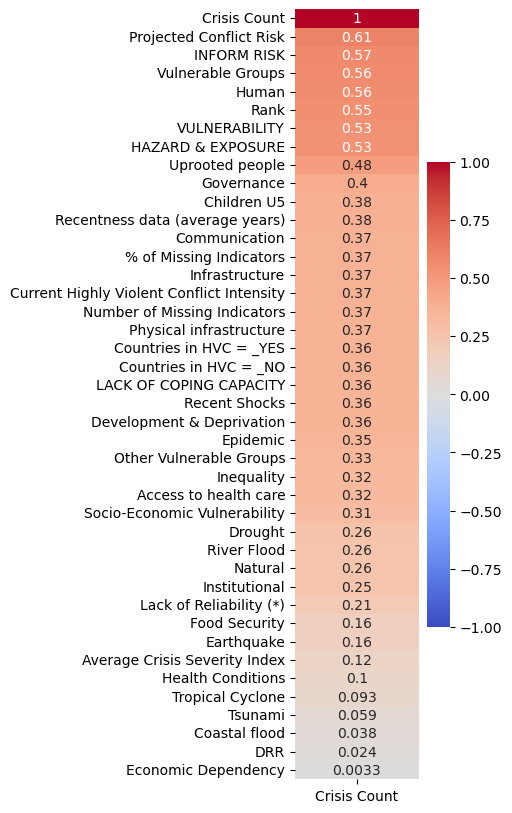

In [120]:
corr = merged_df.corr()

index_corr = corr.loc[["Crisis Count"]].transpose().abs()
index_corr = index_corr.sort_values(by='Crisis Count', ascending=False)

plt.figure(figsize=(2,10))
sns.heatmap(data=index_corr, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.show()

In [60]:
indicators = pd.read_csv('INFORM Risk Indicators.csv')

In [65]:
indicators.head()

,COUNTRY,ISO3,Physical exposure to earthquake MMI VI,Physical exposure to earthquake MMI VIII,Annual Expected Exposed People to River Floods,Annual Expected Exposed People to Tsunamis,Annual Expected Exposed People to Cyclone's Wind SS1,Annual Expected Exposed People to Cyclone's Wind SS3,Annual Expected Exposed People to Coastal Floods,Total affected by Drought,...,People using at least basic sanitation services (% of population),People using at least basic drinking water services (% of population),Physicians Density,Proportion of the target population with access to 3 doses of diphtheria-tetanus-pertussis (DTP3) (%),Proportion of the target population with access to measles-containing-vaccine second-dose (MCV2) (%),Proportion of the target population with access to pneumococcal conjugate 3rd dose (PCV3) (%),Current health expenditure per capita,Maternal Mortality Ratio (modeled estimate),GDP per capita (current US$),Land area (sq. km)
0,Afghanistan,AFG,80872,38334,301049,0,0,0,0,886000,...,50.5,75.1,2.54,66,44,65,322.53,620.00,364,652230
1,Albania,ALB,5974,4731,7454,41,0,0,21706,91429,...,99.3,95.1,18.75,98,92,89,895.59,8.00,6803,27400
2,Algeria,DZA,75089,22015,18114,1,0,0,70,0,...,86.0,94.4,17.19,91,77,91,735.75,78.00,4274,2381740
3,Angola,AGO,0,0,20930,0,0,0,2344,197920,...,51.7,57.2,2.14,45,32,34,184.14,222.00,2999,1246700
4,Antigua and Barbuda,ATG,189,0,0,0,9331,1589,160,0,...,87.5,96.7,27.67,92,76,No data,1082.49,21.00,18745,440


In [64]:
indicators.rename(columns={'Unnamed: 1': 'ISO3'}, inplace=True)

In [66]:
indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 78 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   COUNTRY                                                                                                191 non-null    object 
 1   ISO3                                                                                                   191 non-null    object 
 2   Physical exposure to earthquake MMI VI                                                                 191 non-null    int64  
 3   Physical exposure to earthquake MMI VIII                                                               191 non-null    int64  
 4   Annual Expected Exposed People to River Floods                                                    

In [69]:
indicators.isna().sum()

COUNTRY                                                                                                  0
ISO3                                                                                                     0
Physical exposure to earthquake MMI VI                                                                   0
Physical exposure to earthquake MMI VIII                                                                 0
Annual Expected Exposed People to River Floods                                                           0
Annual Expected Exposed People to Tsunamis                                                               0
Annual Expected Exposed People to Cyclone's Wind SS1                                                     0
Annual Expected Exposed People to Cyclone's Wind SS3                                                     0
Annual Expected Exposed People to Coastal Floods                                                         0
Total affected by Drought            

In [70]:
merged_df.head()

,COUNTRY,ISO3,INFORM RISK,RISK CLASS,Rank,Lack of Reliability (*),HAZARD & EXPOSURE,Natural,Earthquake,River Flood,...,Physical infrastructure,Access to health care,Number of Missing Indicators,% of Missing Indicators,Recentness data (average years),Countries in HVC = _NO,Countries in HVC = _YES,Crisis Count,Average Crisis Severity Index,Average Crisis Severity Category
0,Afghanistan,AFG,8.1,Very High,4.0,-187.4,8.7,5.7,8.7,7.3,...,6.5,8.1,4.0,0.08,-28.31,0,1,2.0,3.6,High
1,Albania,ALB,3.1,Low,104.0,-156.3,3.4,5.7,8.3,4.6,...,1.4,3.4,6.0,0.12,-29.61,1,0,0.0,NaN,NaN
2,Algeria,DZA,3.6,Medium,81.0,-144.2,3.8,3.2,7.9,3.6,...,4.1,4.1,0.0,0.00,-27.04,1,0,4.0,2.6,Medium
3,Angola,AGO,5.2,High,32.0,-142.3,4.2,2.9,0.1,3.9,...,7.9,7.8,0.0,0.00,-26.69,1,0,1.0,3.1,High
4,Antigua and Barbuda,ATG,2.3,Low,151.0,-183.8,2.0,3.7,5.1,0.0,...,0.7,3.1,18.0,0.35,-35.21,1,0,0.0,NaN,NaN


In [85]:
df3 = merged_df[['COUNTRY', 'ISO3', 'INFORM RISK', 'RISK CLASS', 'Crisis Count', 'Average Crisis Severity Index', 'Average Crisis Severity Category']]

In [86]:
df3.head()

,COUNTRY,ISO3,INFORM RISK,RISK CLASS,Crisis Count,Average Crisis Severity Index,Average Crisis Severity Category
0,Afghanistan,AFG,8.1,Very High,2.0,3.6,High
1,Albania,ALB,3.1,Low,0.0,NaN,NaN
2,Algeria,DZA,3.6,Medium,4.0,2.6,Medium
3,Angola,AGO,5.2,High,1.0,3.1,High
4,Antigua and Barbuda,ATG,2.3,Low,0.0,NaN,NaN


In [82]:
population = pd.read_csv('Population 2023.csv')

In [88]:
population.head()

,ISO3,Population
0,AFG,42239854
1,ALB,2832439
2,DZA,45606480
3,AGO,36684202
4,ATG,94298


In [84]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COUNTRY     191 non-null    object
 1   ISO3        191 non-null    object
 2   Population  191 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.6+ KB


In [87]:
population.drop(columns='COUNTRY', inplace=True)

In [89]:
df3 = pd.merge(df3, population, on='ISO3', how='left')

In [90]:
df3.head()

,COUNTRY,ISO3,INFORM RISK,RISK CLASS,Crisis Count,Average Crisis Severity Index,Average Crisis Severity Category,Population
0,Afghanistan,AFG,8.1,Very High,2.0,3.6,High,42239854
1,Albania,ALB,3.1,Low,0.0,NaN,NaN,2832439
2,Algeria,DZA,3.6,Medium,4.0,2.6,Medium,45606480
3,Angola,AGO,5.2,High,1.0,3.1,High,36684202
4,Antigua and Barbuda,ATG,2.3,Low,0.0,NaN,NaN,94298


In [91]:
merged_df2 = pd.merge(df3, indicators, on='ISO3', how='left')

In [92]:
merged_df2.head()

,COUNTRY_x,ISO3,INFORM RISK,RISK CLASS,Crisis Count,Average Crisis Severity Index,Average Crisis Severity Category,Population,COUNTRY_y,Physical exposure to earthquake MMI VI,...,People using at least basic sanitation services (% of population),People using at least basic drinking water services (% of population),Physicians Density,Proportion of the target population with access to 3 doses of diphtheria-tetanus-pertussis (DTP3) (%),Proportion of the target population with access to measles-containing-vaccine second-dose (MCV2) (%),Proportion of the target population with access to pneumococcal conjugate 3rd dose (PCV3) (%),Current health expenditure per capita,Maternal Mortality Ratio (modeled estimate),GDP per capita (current US$),Land area (sq. km)
0,Afghanistan,AFG,8.1,Very High,2.0,3.6,High,42239854,Afghanistan,80872,...,50.5,75.1,2.54,66,44,65,322.53,620.00,364,652230
1,Albania,ALB,3.1,Low,0.0,NaN,NaN,2832439,Albania,5974,...,99.3,95.1,18.75,98,92,89,895.59,8.00,6803,27400
2,Algeria,DZA,3.6,Medium,4.0,2.6,Medium,45606480,Algeria,75089,...,86.0,94.4,17.19,91,77,91,735.75,78.00,4274,2381740
3,Angola,AGO,5.2,High,1.0,3.1,High,36684202,Angola,0,...,51.7,57.2,2.14,45,32,34,184.14,222.00,2999,1246700
4,Antigua and Barbuda,ATG,2.3,Low,0.0,NaN,NaN,94298,Antigua and Barbuda,189,...,87.5,96.7,27.67,92,76,No data,1082.49,21.00,18745,440


In [93]:
merged_df2 = merged_df2.drop(columns='COUNTRY_y')


In [94]:
merged_df2.rename(columns={'COUNTRY_x':'COUNTRY'}, inplace=True)

In [126]:
merged_df2['Crisis Boolean'] = merged_df2['Crisis Count'] != 0

In [97]:
merged_df2.tail()

,COUNTRY,ISO3,INFORM RISK,RISK CLASS,Crisis Count,Average Crisis Severity Index,Average Crisis Severity Category,Population,Physical exposure to earthquake MMI VI,Physical exposure to earthquake MMI VIII,...,People using at least basic sanitation services (% of population),People using at least basic drinking water services (% of population),Physicians Density,Proportion of the target population with access to 3 doses of diphtheria-tetanus-pertussis (DTP3) (%),Proportion of the target population with access to measles-containing-vaccine second-dose (MCV2) (%),Proportion of the target population with access to pneumococcal conjugate 3rd dose (PCV3) (%),Current health expenditure per capita,Maternal Mortality Ratio (modeled estimate),GDP per capita (current US$),Land area (sq. km)
186,Venezuela,VEN,4.7,Medium,2.0,4.05,Very High,28838499,54822,18947,...,95.8,93.7,17.30,56,37,0,590.12,259.00,No data,882050
187,Viet Nam,VNM,3.7,Medium,0.0,NaN,NaN,98858950,35102,0,...,89.2,96.9,8.28,83,85,No data,516.18,124.00,4164,310070
188,Yemen,YEM,7.5,Very High,2.0,3.50,High,34449825,3290,0,...,54.1,60.7,5.25,72,52,72,102.29,183.00,677,527970
189,Zambia,ZMB,3.9,Medium,2.0,3.60,High,20569737,7345,0,...,31.9,65.4,1.17,91,81,89,188.66,135.00,1488,743390
190,Zimbabwe,ZWE,4.1,Medium,2.0,3.90,High,16665409,3192,0,...,35.2,62.7,1.99,86,74,86,118.13,357.00,1267,386850


In [133]:
merged_df2['Crisis Count'].unique().tolist()

[2.0, 0.0, 4.0, 1.0, 3.0, 5.0, 10.0, 6.0, 7.0]

In [ ]:
merged_df2

C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\3646251027.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr2 = merged_df2.corr()


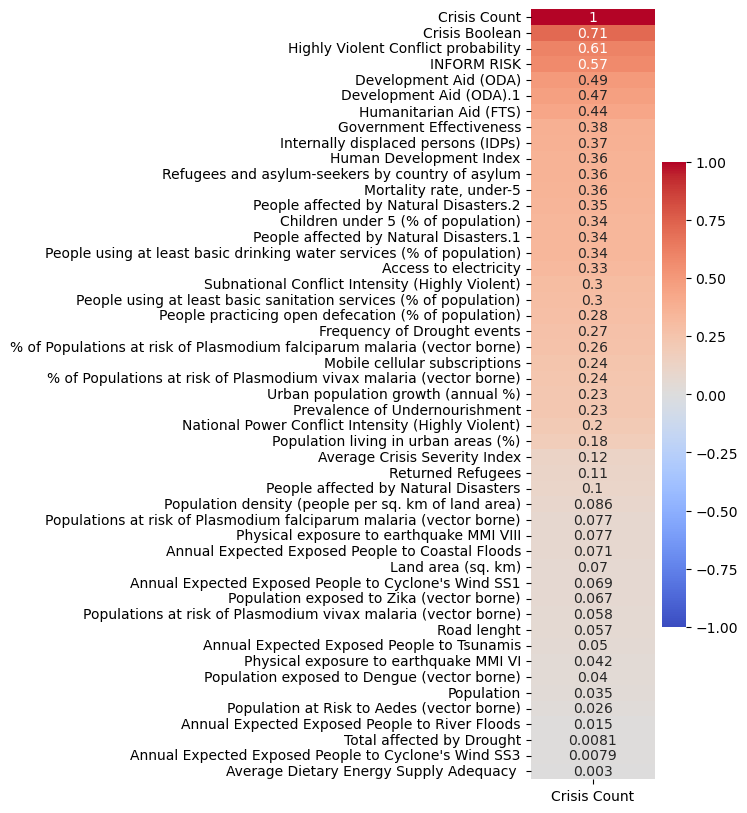

In [130]:
corr2 = merged_df2.corr()

index_corr2 = corr2.loc[["Crisis Count"]].transpose().abs()
index_corr2 = index_corr2.sort_values(by='Crisis Count', ascending=False)

plt.figure(figsize=(2,10))
sns.heatmap(data=index_corr2, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.show()

C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\353340465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr22 = merged_df2.corr()


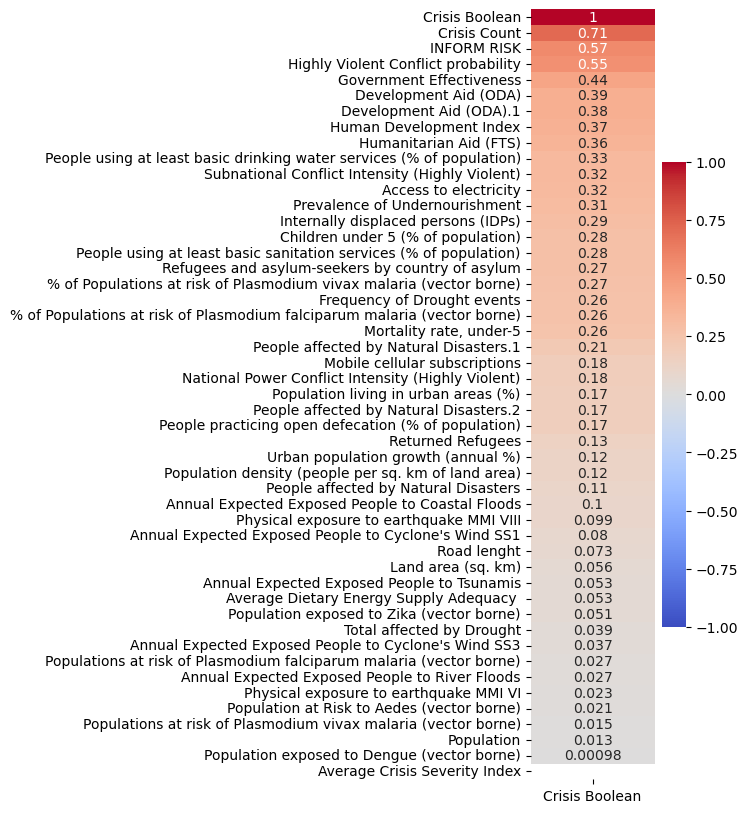

In [129]:
corr22 = merged_df2.corr()

index_corr22 = corr22.loc[["Crisis Boolean"]].transpose().abs()
index_corr22 = index_corr22.sort_values(by='Crisis Boolean', ascending=False)

plt.figure(figsize=(2,10))
sns.heatmap(data=index_corr22, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.show()

C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\4184315642.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr21 = merged_df2.corr()


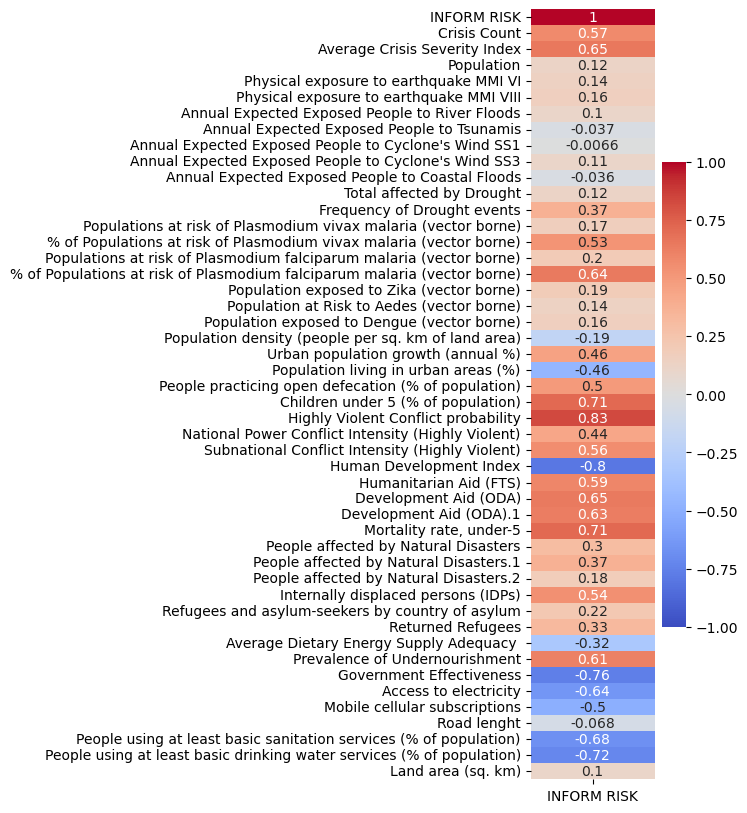

In [104]:
corr21 = merged_df2.corr()

index_corr21 = corr21.loc[["INFORM RISK"]].transpose()

plt.figure(figsize=(2,10))
sns.heatmap(data=index_corr21, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.show()

In [98]:
crisis_df = merged_df2[merged_df2['Crisis Count'] != 0]

In [134]:
crisis_df.head()

,COUNTRY,ISO3,INFORM RISK,RISK CLASS,Crisis Count,Average Crisis Severity Index,Average Crisis Severity Category,Population,Physical exposure to earthquake MMI VI,Physical exposure to earthquake MMI VIII,...,People using at least basic sanitation services (% of population),People using at least basic drinking water services (% of population),Physicians Density,Proportion of the target population with access to 3 doses of diphtheria-tetanus-pertussis (DTP3) (%),Proportion of the target population with access to measles-containing-vaccine second-dose (MCV2) (%),Proportion of the target population with access to pneumococcal conjugate 3rd dose (PCV3) (%),Current health expenditure per capita,Maternal Mortality Ratio (modeled estimate),GDP per capita (current US$),Land area (sq. km)
0,Afghanistan,AFG,8.1,Very High,2.0,3.6,High,42239854,80872,38334,...,50.5,75.1,2.54,66,44,65,322.53,620.00,364,652230
2,Algeria,DZA,3.6,Medium,4.0,2.6,Medium,45606480,75089,22015,...,86.0,94.4,17.19,91,77,91,735.75,78.00,4274,2381740
3,Angola,AGO,5.2,High,1.0,3.1,High,36684202,0,0,...,51.7,57.2,2.14,45,32,34,184.14,222.00,2999,1246700
6,Armenia,ARM,2.9,Low,2.0,2.5,Medium,2777970,5878,1900,...,93.9,100.0,29.14,93,94,93,1721.09,27.00,7014,28480
9,Azerbaijan,AZE,4.8,Medium,2.0,2.4,Medium,10412652,21752,5965,...,96.1,96.0,31.68,89,90,90,655.92,41.00,7737,82658


C:\Users\Huawei MateBook D14\AppData\Local\Temp\ipykernel_8132\1953555024.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr3 = crisis_df.corr()


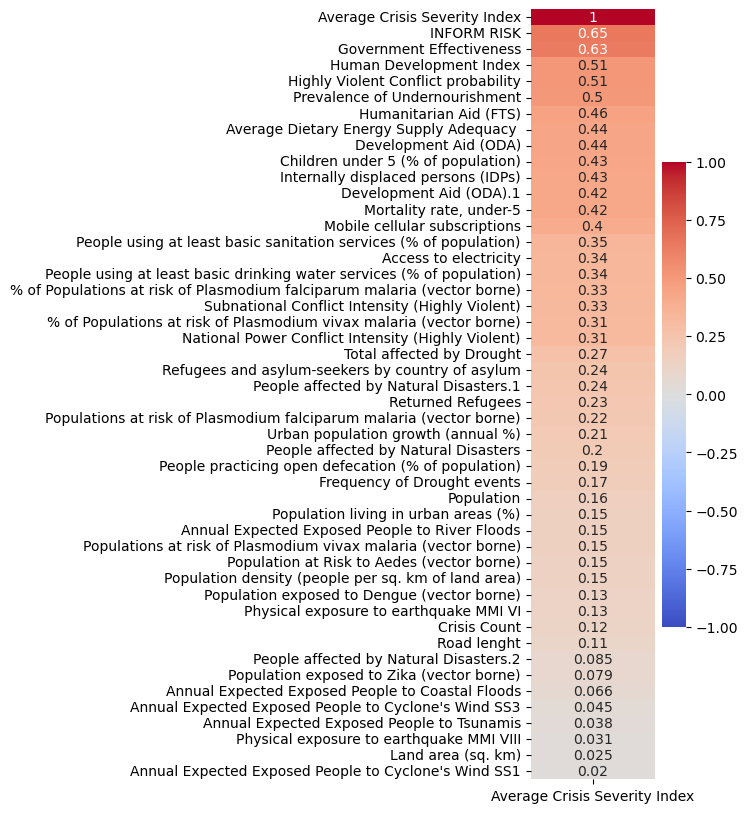

In [137]:
corr3 = crisis_df.corr()

index_corr3 = corr3.loc[["Average Crisis Severity Index"]].transpose().abs()
index_corr3 = index_corr3.sort_values(by='Average Crisis Severity Index', ascending=False)

plt.figure(figsize=(2,10))
sns.heatmap(data=index_corr3, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.show()

In [127]:
merged_df2.head()

,COUNTRY,ISO3,INFORM RISK,RISK CLASS,Crisis Count,Average Crisis Severity Index,Average Crisis Severity Category,Population,Physical exposure to earthquake MMI VI,Physical exposure to earthquake MMI VIII,...,People using at least basic drinking water services (% of population),Physicians Density,Proportion of the target population with access to 3 doses of diphtheria-tetanus-pertussis (DTP3) (%),Proportion of the target population with access to measles-containing-vaccine second-dose (MCV2) (%),Proportion of the target population with access to pneumococcal conjugate 3rd dose (PCV3) (%),Current health expenditure per capita,Maternal Mortality Ratio (modeled estimate),GDP per capita (current US$),Land area (sq. km),Crisis Boolean
0,Afghanistan,AFG,8.1,Very High,2.0,3.6,High,42239854,80872,38334,...,75.1,2.54,66,44,65,322.53,620.00,364,652230,True
1,Albania,ALB,3.1,Low,0.0,NaN,NaN,2832439,5974,4731,...,95.1,18.75,98,92,89,895.59,8.00,6803,27400,False
2,Algeria,DZA,3.6,Medium,4.0,2.6,Medium,45606480,75089,22015,...,94.4,17.19,91,77,91,735.75,78.00,4274,2381740,True
3,Angola,AGO,5.2,High,1.0,3.1,High,36684202,0,0,...,57.2,2.14,45,32,34,184.14,222.00,2999,1246700,True
4,Antigua and Barbuda,ATG,2.3,Low,0.0,NaN,NaN,94298,189,0,...,96.7,27.67,92,76,No data,1082.49,21.00,18745,440,False


## Let's do machine learning

Predicting Crisis Count: 
- Risk INDEX only

Then: 
- Risk INDEX
- Highly Violent Conflict Probability
- Government Effectiveness
- Humanitarian Aid 
- Development Aid

Predicting Crisis Severity: 
- Risk INDEX only 

Then: 
- Risk INDEX
- Government Effectiveness
- Human Development Index
- Highly Violent Conflict Probability 
- Prevalance of Undernourishment


CRISIS TYPE ????

In [132]:
merged_df2.to_csv('merged_df2.csv')

In [136]:
crisis_df.to_csv('crisis_df.csv')